In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lineticks import LineTicks

In [2]:
from IPython.core.display import HTML

# Center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Building on the previous model

This model builds on the previous model with stepped initial conditions.

First, let's set up that model. We define functions for the diffusion terms:

In [3]:
def Ai(D_v, a_s, a_l, d_s):
    return (6. * D_v * a_s) / (a_l * d_s**2)

def G(D_v, a_s, a_l, d_s, c_s, c_l):
    return Ai(D_v, a_s, a_l, d_s) * (c_s - c_l)

def H(D_v, phi_v, d_s, c_s, c_l):
    return (6. * D_v) / (phi_v * d_s**2) * (c_s - c_l)

And a function to compute the update step:

In [4]:
def update(y, t, v_l, dz, D_v1, D_v2, a_s1, a_l, d_s1, a_s2, d_s2, phi_v1, phi_v2):
    # Parse the interleaved data
    c_l = y[::3]
    c_s1 = y[1::3]
    c_s2 = y[2::3]
    
    # Initialize the return value
    dy_dt = np.empty_like(y)
    
    # Interleaved views of the return value
    dcl_dt = dy_dt[::3]
    dcs1_dt = dy_dt[1::3]
    dcs2_dt = dy_dt[2::3]
    
    # Compute derivatives
    dcl_dt[0] = -v_l * c_l[0] / dz + \
        G(D_v1, a_s1, a_l, d_s1, c_s1[0], c_l[0]) + \
        G(D_v2, a_s2, a_l, d_s2, c_s2[0], c_l[0])
    dcl_dt[1:] = -v_l * (c_l[1:] - c_l[:-1]) / dz + \
        G(D_v1, a_s1, a_l, d_s1, c_s1[1:], c_l[1:]) + \
        G(D_v2, a_s2, a_l, d_s2, c_s2[1:], c_l[1:])

    dcs1_dt[:] = -H(D_v1, phi_v1, d_s1, c_s1, c_l)
    dcs2_dt[:] = -H(D_v2, phi_v2, d_s2, c_s2, c_l)
    
    return dy_dt

Now we define some constants for the model:

In [5]:
# Global constants
a_l = 0.2
a_s1 = 0.5
a_s2 = 0.3

Q = 250. / (1e2)**3 / 60.
A = np.pi * (59e-3 / 2)**2
v_l = Q / (a_l * A)

L = 0.0405
N = 100
dz = L / N

d_s1 = 2.517e-5
d_s2 = 5.63e-4

rho_l = 965.3
h_sl1 = 5.1207e-4 / rho_l
h_sl2 = 1.43e-3 / rho_l

D_v1 = d_s1 * h_sl1
D_v2 = d_s2 * h_sl2

phi_v1 = 0.56
phi_v2 = 0.56

dt = 0.05
num_t = round(250. / dt)

c_s = 358.587

args = (v_l, dz, D_v1, D_v2, a_s1, a_l, d_s1, a_s2, d_s2, phi_v1, phi_v2)
args_without_flow = (0., dz, D_v1, D_v2, a_s1, a_l, d_s1, a_s2, d_s2, phi_v1, phi_v2)

And initial conditions:

In [6]:
def initial_conditions():
    # Initial values
    cl_0 = np.array([0.] * N)
    cs1_0 = np.array([c_s] * N)
    cs2_0 = np.array([c_s] * N)

    y0 = np.empty(3 * N)
    y0[::3] = cl_0
    y0[1::3] = cs1_0
    y0[2::3] = cs2_0
    
    # Time step for initialization
    dt_init = dz/v_l
    t_init = np.linspace(-N * dt_init, 0., N+1)
    
    for i in range(len(t_init)):
        # Advance the fluid
        c_l = y0[::3]
        c_l[1:] = c_l[:-1]
        c_l[0] = 0.

        # Update with no flow
        sol = odeint(update, y0, t_init[i:i+2], args_without_flow, ml=3, mu=2)
        y0[:i*3] = sol[-1][:i*3]
    
    return y0

Let's add preinfusion:

In [7]:
# Initial conditions
y0 = initial_conditions()

# Preinfusion time
t_preinfusion = 10.
t = np.linspace(0., t_preinfusion, round(t_preinfusion / dt))

# Model preinfusion
sol = odeint(update, y0, t, args_without_flow, ml=3, mu=2)
sol

array([[  0.        , 110.52943146, 309.42034564, ..., 297.9898329 ,
        358.587     , 358.587     ],
       [  2.09602002, 109.29420575, 308.98379323, ..., 299.01039274,
        357.90906519, 358.50193916],
       [  4.13687788, 108.09625392, 308.55078693, ..., 300.00304609,
        357.25013637, 358.41842368],
       ...,
       [ 89.03881251,  81.94440213, 251.06347487, ..., 336.09109617,
        335.62464155, 351.49895067],
       [ 89.11874158,  82.02490189, 250.83415495, ..., 336.10195793,
        335.62996616, 351.47714564],
       [ 89.19831494,  82.10539319, 250.60527258, ..., 336.11269445,
        335.63535254, 351.45538677]])

And finally we run the model:

In [8]:
# Initial conditions
y0 = sol[-1]

# Simulation time
t = np.linspace(0., num_t * dt, num_t)

# Model the shot
sol = odeint(update, y0, t, args, ml=3, mu=2)
sol

array([[8.91983149e+01, 8.21053932e+01, 2.50605273e+02, ...,
        3.36112694e+02, 3.35635353e+02, 3.51455387e+02],
       [3.52485568e+01, 8.18339371e+01, 2.50333877e+02, ...,
        3.34939812e+02, 3.35634121e+02, 3.51432945e+02],
       [1.45435026e+01, 8.11760742e+01, 2.50013962e+02, ...,
        3.33760148e+02, 3.35619695e+02, 3.51408877e+02],
       ...,
       [2.78460513e-04, 3.18128034e-04, 2.20658831e-01, ...,
        6.36017538e-02, 7.21197153e-02, 7.52876484e-01],
       [2.78068685e-04, 3.17680389e-04, 2.20348338e-01, ...,
        6.35169691e-02, 7.20235872e-02, 7.51905307e-01],
       [2.77677409e-04, 3.17233375e-04, 2.20038281e-01, ...,
        6.34322974e-02, 7.19275872e-02, 7.50935379e-01]])

Finally, we plot concentration at the outlet vs. time:

Text(0, 0.5, 'Concentration of Soluble Coffee (kg/m^3)')

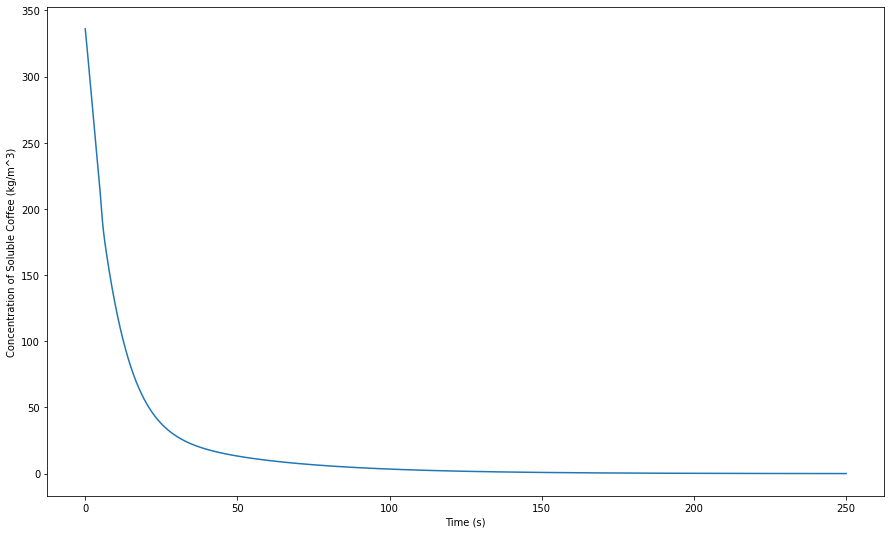

In [9]:
# Get values at the outlet
c_l = sol[:,-3]

# Plot the values
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(t, c_l)

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration of Soluble Coffee (kg/m^3)')

# Plotting TDS vs. EY

Now we can integrate to get the mass of solubles and liquid at the output:

In [10]:
in_s = 0.06
out_s = np.cumsum(Q * (c_l[1:] + c_l[:-1]) / 2. * dt)
out_l = Q * 1e3 * t[1:]

Then we can plot TDS vs. EY.

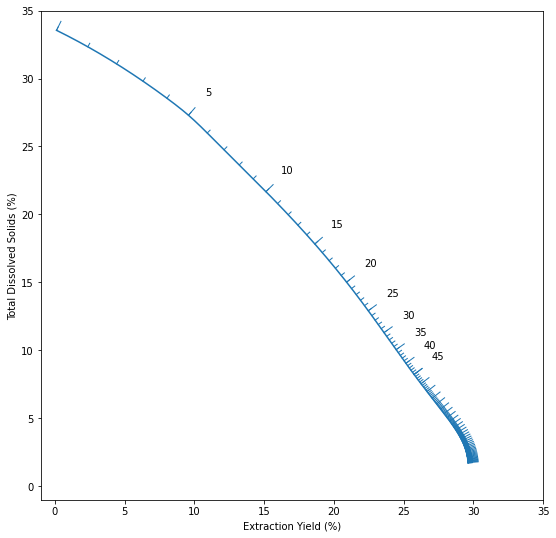

In [11]:
fig, ax = plt.subplots(figsize=(9,9))

# Plot the values
traj, = ax.plot(100. * out_s / in_s, 100. * out_s / out_l)

# Label the axes
ax.set_xlabel('Extraction Yield (%)')
ax.set_ylabel('Total Dissolved Solids (%)')

# Set axis limits
plt.xlim([-1., 35.])
plt.ylim([-1., 35.])

# Draw ticks to indicate time
major_ticks = LineTicks(traj, range(0, 901, 100), 10, lw=1, label=['{:.0f}'.format(round(tt)) for tt in t[::100]])
minor_ticks = LineTicks(traj, range(0, 901, 20), 4, lw=1)

n = len(out_s)
major_ticks = LineTicks(traj, range(901, n, 100), 10, lw=1)
minor_ticks = LineTicks(traj, range(901, n, 20), 4, lw=1)

# Concentration profiles

Finally, we can look at how concentration changes throughout the puck over time.

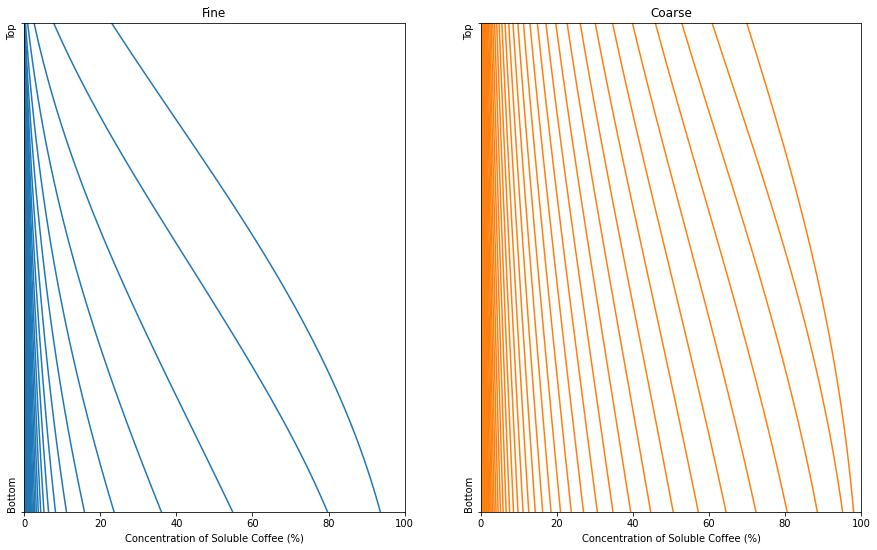

In [12]:
def plot_profile(ax, title, color, c_si):
    ax.set_xlabel('Concentration of Soluble Coffee (%)')
    ax.title.set_text(title)

    depths = np.linspace(0., 100., 100)

    for vals in c_si:
        ax.plot(vals, depths, c=color)

    ax.set_xlim([0., 100.])
    ax.set_ylim([100., 0.])

    plt.sca(ax)
    plt.yticks(rotation = 90)

    ax.set_yticks([100., 0.])
    ax.set_yticklabels(['Bottom', 'Top'])
    ax.yaxis.get_majorticklabels()[0].set_verticalalignment("bottom")
    ax.yaxis.get_majorticklabels()[1].set_verticalalignment("top")

fig, axs = plt.subplots(1, 2, figsize=(15,9))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

c_s1 = sol[::100,1::3] / c_s * 100.
c_s2 = sol[::100,2::3] / c_s * 100.

plot_profile(axs[0], 'Fine', colors[0], c_s1)
plot_profile(axs[1], 'Coarse', colors[1], c_s2)